Running Hill Climbing...
Running Simulated Annealing...
Running Hill Climbing...
Running Simulated Annealing...
8-Queens Results:
Hill Climbing: 0.0% solved, costs: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Simulated Annealing: 30.0% solved, costs: [4, 10, 8, 0, 6, 0, 10, 0, 10, 2]
8-Puzzle Results:
Hill Climbing: 0.0% solved, costs: [8, 6, 12, 10, 11, 10, 16, 14, 16, 12]
Simulated Annealing: 0.0% solved, costs: [6, 6, 8, 4, 2, 6, 6, 6, 6, 6]


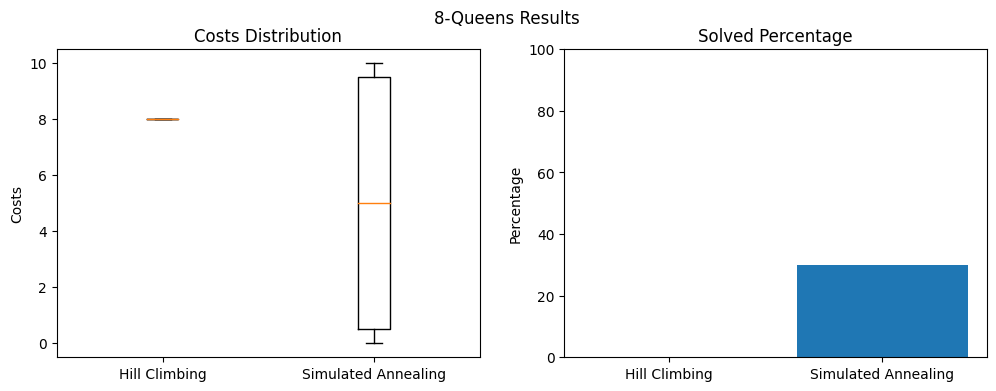

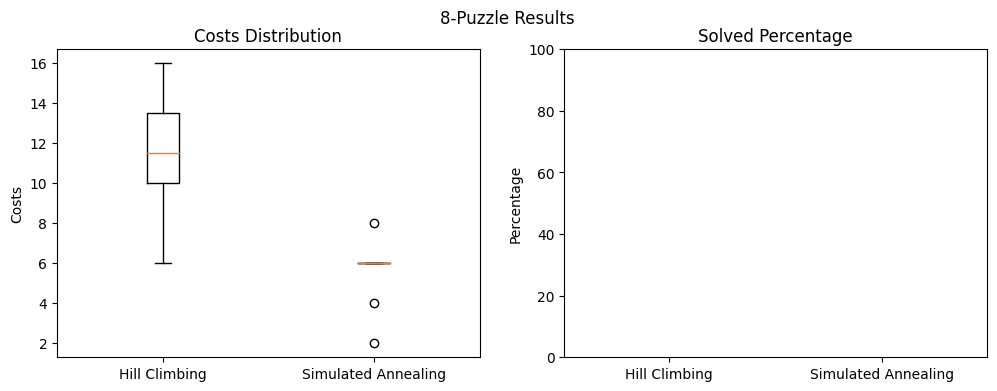

In [1]:
import sys
import random
import math
import numpy as np
import time
import matplotlib.pyplot as plt

# Problem class definition
class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value. Hill Climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError

# Node class definition
class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
   that this is a successor of) and to the actual state for this node. Note
   that if a state is arrived at by two paths, then there are two nodes with
   the same state. Also includes the action that got us to this state, and
   the total path_cost (also known as g) to reach the node. Other functions
   may add an f and h value; see best_first_graph_search and astar_search for
   an explanation of how the f and h values are handled. You will not need to
   subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)

#NQueensProblem class definition
class NQueensProblem(Problem):
    """The problem of placing N queens on an NxN board with none attacking
    each other. A state is represented as an N-element array, where
    a value of r in the c-th entry means there is a queen at column c,
    row r, and a value of -1 means that the c-th column has not been
    filled in yet. We fill in columns left to right.
    >>> depth_first_tree_search(NQueensProblem(8))
    <Node (7, 3, 0, 2, 5, 1, 6, 4)>
    """

    def __init__(self, N):
        super().__init__(tuple([-1] * N))
        self.N = N

    def actions(self, state):
        """In the leftmost empty column, try all non-conflicting rows."""
        if state[-1] != -1:
            return []  # All columns filled; no successors
        else:
            col = state.index(-1)
            return [row for row in range(self.N)
                    if not self.conflicted(state, row, col)]

    def result(self, state, row):
        """Place the next queen at the given row."""
        col = state.index(-1)
        new = list(state[:])
        new[col] = row
        return tuple(new)

    def conflicted(self, state, row, col):
        """Would placing a queen at (row, col) conflict with anything?"""
        return any(self.conflict(row, col, state[c], c)
                   for c in range(col))

    def conflict(self, row1, col1, row2, col2):
        """Would putting two queens in (row1, col1) and (row2, col2) conflict?"""
        return (row1 == row2 or  # same row
                col1 == col2 or  # same column
                row1 - col1 == row2 - col2 or  # same \ diagonal
                row1 + col1 == row2 + col2)  # same / diagonal

    def goal_test(self, state):
        """Check if all columns filled, no conflicts."""
        if state[-1] == -1:
            return False
        return not any(self.conflicted(state, state[col], col)
                       for col in range(len(state)))

    def h(self, node):
        """Return number of conflicting queens for a given node"""
        num_conflicts = 0
        for (r1, c1) in enumerate(node.state):
            for (r2, c2) in enumerate(node.state):
                if (r1, c1) != (r2, c2):
                    num_conflicts += self.conflict(r1, c1, r2, c2)

        return num_conflicts

    def cost(self, state):
        """Return the number of conflicts in the state."""
        num_conflicts = 0
        for (r1, c1) in enumerate(state):
            for (r2, c2) in enumerate(state):
                if (r1, c1) != (r2, c2):
                    num_conflicts += self.conflict(r1, c1, r2, c2)
        return num_conflicts

    def value(self, state):
        """Return the negative of the number of conflicts in the state."""
        return -self.cost(state)

#EightPuzzle class definition
class EightPuzzle(Problem):

    def __init__(self, initial):
        self.initial = initial

    def actions(self, state):
        blank = state.index(0)
        row, col = divmod(blank, 3)
        actions = []

        if row > 0:
            actions.append('UP')
        if row < 2:
            actions.append('DOWN')
        if col > 0:
            actions.append('LEFT')
        if col < 2:
            actions.append('RIGHT')

        return actions

    def result(self, state, action):
        state = list(state)
        blank = state.index(0)
        row, col = divmod(blank, 3)

        if action == 'UP':
            swap_with = blank - 3
        elif action == 'DOWN':
            swap_with = blank + 3
        elif action == 'LEFT':
            swap_with = blank - 1
        elif action == 'RIGHT':
            swap_with = blank + 1

        state[blank], state[swap_with] = state[swap_with], state[blank]
        return tuple(state)

    def goal_test(self, state):
        return state == (0, 1, 2, 3, 4, 5, 6, 7, 8)

    def cost(self, state):
        """Return the sum of Manhattan distances for each tile."""
        cost = 0
        for i in range(9):
            tile = state[i]
            if tile != 0:
                current_row, current_col = divmod(i, 3)
                goal_row, goal_col = divmod(tile, 3)
                cost += abs(current_row - goal_row) + abs(current_col - goal_col)
        return cost

    def value(self, state):
        """Return the negative of the sum of Manhattan distances for each tile."""
        return -self.cost(state)

# Function to generate random N-Queens instances
def random_n_queens_instance(size):
    return NQueensProblem(size)

# Function to generate random eight puzzle instances
def random_eight_puzzle_instance():
    state = list(range(9))
    random.shuffle(state)
    return EightPuzzle(tuple(state))

# Hill Climbing algorithm implementation
def hill_climbing(problem):
    current = Node(problem.initial)
    while True:
        neighbors = current.expand(problem)
        if not neighbors:
            break
        neighbor = max(neighbors, key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) <= problem.value(current.state):
            break
        current = neighbor
    return current  # Return the current Node, not the state

# Simulated Annealing algorithm implementation
def simulated_annealing(problem, schedule):
    current = Node(problem.initial)
    for t in range(sys.maxsize):
        T = schedule(t)
        if T == 0:
            return current  # Return the current Node, not the state
        neighbors = current.expand(problem)
        if not neighbors:
            return current  # Return the current Node, not the state
        next_choice = random.choice(neighbors)
        delta_e = problem.value(next_choice.state) - problem.value(current.state)
        if delta_e > 0 or random.uniform(0, 1) < math.exp(delta_e / T):
            current = next_choice
    return current  # Return the current Node, not the state

# Exponential schedule for Simulated Annealing
def exponential_schedule(k=50, lam=0.01, limit=1000000):
    return lambda t: (k * math.exp(-lam * t) if t < limit else 0)

# Function to run an experiment with multiple search algorithms
def run_experiment(problem_generator, algorithms, num_instances=100, time_limit=60):
    results = {}
    for algo_name, algo_func in algorithms.items():
        print(f"Running {algo_name}...")
        costs = []
        solved = 0
        for i in range(num_instances):
            problem_instance = problem_generator()
            start_time = time.time()
            result = algo_func(problem_instance)
            elapsed_time = time.time() - start_time
            if elapsed_time > time_limit:
                print(f"{algo_name} took too long to solve instance.")
                continue
            cost = problem_instance.cost(result.state)
            costs.append(cost)
            if problem_instance.goal_test(result.state):
                solved += 1
        solved_percentage = (solved / num_instances) * 100
        results[algo_name] = {"costs": costs, "solved_percentage": solved_percentage}
    return results

# Define search algorithms
search_algorithms = {
    "Hill Climbing": lambda problem: hill_climbing(problem),
    "Simulated Annealing": lambda problem: simulated_annealing(problem, exponential_schedule())
}

# Function to plot the results of the experiments
def plot_results(results, title):
    algorithms = results.keys()
    costs = [result["costs"] for result in results.values()]
    solved_percentages = [result["solved_percentage"] for result in results.values()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title)
    
    # Box plot for costs
    ax1.boxplot(costs, labels=algorithms)
    ax1.set_ylabel("Costs")
    ax1.set_title("Costs Distribution")
    
    # Bar plot for solved percentages
    ax2.bar(algorithms, solved_percentages)
    ax2.set_ylabel("Percentage")
    ax2.set_ylim([0, 100])
    ax2.set_title("Solved Percentage")
    
    plt.show()
    
# Main Function
if __name__ == '__main__':
         # Run experiments with N-Queens and 8-Puzzle problems
    n_queens_results = run_experiment(lambda: random_n_queens_instance(8), search_algorithms, num_instances=10)
    eight_puzzle_results = run_experiment(lambda: random_eight_puzzle_instance(), search_algorithms, num_instances=10)

         # Print results for N-Queens and 8-Puzzle problems
    print("8-Queens Results:")
    for algo_name, result in n_queens_results.items():
        print(f"{algo_name}: {result['solved_percentage']}% solved, costs: {result['costs']}")

    print("8-Puzzle Results:")
    for algo_name, result in eight_puzzle_results.items():
        print(f"{algo_name}: {result['solved_percentage']}% solved, costs: {result['costs']}")
        
 # Plot the results
    plot_results(n_queens_results, "8-Queens Results")
    plot_results(eight_puzzle_results, "8-Puzzle Results")


In [ ]:
import sys
import random
import math
import numpy as np
import time
import matplotlib.pyplot as plt

# Problem class definition
class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value. Hill Climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError

# Node class definition
class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
   that this is a successor of) and to the actual state for this node. Note
   that if a state is arrived at by two paths, then there are two nodes with
   the same state. Also includes the action that got us to this state, and
   the total path_cost (also known as g) to reach the node. Other functions
   may add an f and h value; see best_first_graph_search and astar_search for
   an explanation of how the f and h values are handled. You will not need to
   subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)

# NQueensProblem class definition
class NQueensProblem(Problem):
    """The problem of placing N queens on an NxN board with none attacking
    each other. A state is represented as an N-element array, where
    a value of r in the c-th entry means there is a queen at column c,
    row r, and a value of -1 means that the c-th column has not been
    filled in yet. We fill in columns left to right.
    >>> depth_first_tree_search(NQueensProblem(8))
    <Node (7, 3, 0, 2, 5, 1, 6, 4)>
    """

    def __init__(self, N, initial=None):
        if initial is None:
            initial = self.random_initial_state(N)
        super().__init__(initial)
        self.N = N

    def actions(self, state):
        """In the leftmost empty column, try all non-conflicting rows."""
        if state[-1] != -1:
            return []  # All columns filled; no successors
        else:
            col = state.index(-1)
            return [row for row in range(self.N)
                    if not self.conflicted(state, row, col)]

    def result(self, state, row):
        """Place the next queen at the given row."""
        col = state.index(-1)
        new = list(state[:])
        new[col] = row
        return tuple(new)

    def conflicted(self, state, row, col):
        """Would placing a queen at (row, col) conflict with anything?"""
        return any(self.conflict(row, col, state[c], c)
                   for c in range(col))

    def conflict(self, row1, col1, row2, col2):
        """Would putting two queens in (row1, col1) and (row2, col2) conflict?"""
        return (row1 == row2 or  # same row
                col1 == col2 or  # same column
                row1 - col1 == row2 - col2 or  # same \ diagonal
                row1 + col1 == row2 + col2)  # same / diagonal

    def goal_test(self, state):
        """Check if all columns filled, no conflicts."""
        if state[-1] == -1:
            return False
        return not any(self.conflicted(state, state[col], col)
                       for col in range(len(state)))

    def h(self, node):
        """Return number of conflicting queens for a given node"""
        num_conflicts = 0
        for (r1, c1) in enumerate(node.state):
            for (r2, c2) in enumerate(node.state):
                if (r1, c1) != (r2, c2):
                    num_conflicts += self.conflict(r1, c1, r2, c2)

        return num_conflicts

    def cost(self, state):
        """Return the number of conflicts in the state."""
        num_conflicts = 0
        for (r1, c1) in enumerate(state):
            for (r2, c2) in enumerate(state):
                if (r1, c1) != (r2, c2):
                    num_conflicts += self.conflict(r1, c1, r2, c2)
        return num_conflicts

    def value(self, state):
        """Return the negative of the number of conflicts in the state."""
        return -self.cost(state)

    @staticmethod
    def random_initial_state(N):
        state = list(range(N))
        random.shuffle(state)
        return tuple(state)

# EightPuzzle class definition
class EightPuzzle(Problem):

    def __init__(self, initial=None):
        if initial is None:
            initial = self.random_initial_state()
        self.initial = initial

    @staticmethod
    def random_initial_state():
        state = list(range(9))
        random.shuffle(state)
        return tuple(state)

    def actions(self, state):
        blank = state.index(0)
        row, col = divmod(blank, 3)
        actions = []

        if row > 0:
            actions.append('UP')
        if row < 2:
            actions.append('DOWN')
        if col > 0:
            actions.append('LEFT')
        if col < 2:
            actions.append('RIGHT')

        return actions

    def result(self, state, action):
        state = list(state)
        blank = state.index(0)
        row, col = divmod(blank, 3)

        if action == 'UP':
            swap_with = blank - 3
        elif action == 'DOWN':
            swap_with = blank + 3
        elif action == 'LEFT':
            swap_with = blank - 1
        elif action == 'RIGHT':
            swap_with = blank + 1

        state[blank], state[swap_with] = state[swap_with], state[blank]
        return tuple(state)

    def goal_test(self, state):
        return state == (0, 1, 2, 3, 4, 5, 6, 7, 8)

    def cost(self, state):
        """Return the sum of Manhattan distances for each tile."""
        cost = 0
        for i in range(9):
            tile = state[i]
            if tile != 0:
                current_row, current_col = divmod(i, 3)
                goal_row, goal_col = divmod(tile, 3)
                cost += abs(current_row - goal_row) + abs(current_col - goal_col)
        return cost

    def value(self, state):
        """Return the negative of the sum of Manhattan distances for each tile."""
        return -self.cost(state)

# Function to generate random N-Queens instances
def random_n_queens_instance(size):
    return NQueensProblem(size)

# Function to generate random 8-Puzzle instances
def random_eight_puzzle_instance():
    state = list(range(9))
    random.shuffle(state)
    return EightPuzzle(tuple(state))

# Hill Climbing algorithm implementation
def hill_climbing(problem, max_restarts=2):
    for _ in range(max_restarts):
        if isinstance(problem, NQueensProblem):
            current = Node(problem.random_initial_state(problem.N))
        else:
            current = Node(problem.random_initial_state())
        while True:
            neighbors = current.expand(problem)
            if not neighbors:
                break
            neighbor = max(neighbors, key=lambda node: problem.value(node.state))
            if problem.value(neighbor.state) <= problem.value(current.state):
                break
            current = neighbor
        if problem.goal_test(current.state):
            return current
    return None  # No solution found within the given number of restarts

# Simulated Annealing algorithm implementation
def simulated_annealing(problem, schedule):
    current = Node(problem.initial)
    for t in range(sys.maxsize):
        T = schedule(t)
        if T == 0:
            return current  
        neighbors = current.expand(problem)
        if not neighbors:
            return current  
        next_choice = random.choice(neighbors)
        delta_e = problem.value(next_choice.state) - problem.value(current.state)
        if delta_e > 0 or random.uniform(0, 1) < math.exp(delta_e / T):
            current = next_choice
    return current  # Return the current Node

# Exponential schedule for Simulated Annealing
def exponential_schedule(k=50, lam=0.01, limit=1000000):
    return lambda t: (k * math.exp(-lam * t) if t < limit else 0)

# Function to run an experiment with multiple search algorithms
def run_experiment(problem_generator, algorithms, num_instances=10, time_limit=60):
    results = {}
    for algo_name, algo_func in algorithms.items():
        # print(f"Running {algo_name}...")
        costs = []
        solved = 0
        for i in range(num_instances):
            problem_instance = problem_generator()
            start_time = time.time()
            result = algo_func(problem_instance)
            elapsed_time = time.time() - start_time
            if elapsed_time > time_limit:
                print(f"{algo_name} took too long to solve instance.")
                continue
            if result is not None:
                cost = problem_instance.cost(result.state)
                costs.append(cost)
                if problem_instance.goal_test(result.state):
                    solved += 1
            else:
                print(f"{algo_name} failed to find a solution.")
        solved_percentage = (solved / num_instances) * 100
        results[algo_name] = {"costs": costs, "solved_percentage": solved_percentage}
    return results

# Function to plot the results of the experiments
def plot_results(results, title):
    algorithms = results.keys()
    costs = [result["costs"] for result in results.values()]
    solved_percentages = [result["solved_percentage"] for result in results.values()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title)
    
    # Box plot for costs
    ax1.boxplot(costs, labels=algorithms)
    ax1.set_ylabel("Costs")
    ax1.set_title("Costs Distribution")
    
    # Bar plot for solved percentages
    ax2.bar(algorithms, solved_percentages)
    ax2.set_ylabel("Percentage")
    ax2.set_ylim([0, 100])
    ax2.set_title("Solved Percentage")
    
    plt.show()
    
# Main function
if __name__ == '__main__':
    
     # Define search algorithms
    search_algorithms = {
    "Hill Climbing": lambda problem: hill_climbing(problem),
    "Simulated Annealing": lambda problem: simulated_annealing(problem, exponential_schedule())
    }
    
     # Run experiments with N-Queens and 8-Puzzle problems
    n_queens_results = run_experiment(lambda: random_n_queens_instance(8), search_algorithms, num_instances=10)
    eight_puzzle_results = run_experiment(lambda: random_eight_puzzle_instance(), search_algorithms, num_instances=10)

     # Print results for N-Queens and 8-Puzzle problems
    print("8-Queens Results:")
    for algo_name, result in n_queens_results.items():
        print(f"{algo_name}: {result['solved_percentage']}% solved, costs: {result['costs']}")

    print("8-Puzzle Results:")
    for algo_name, result in eight_puzzle_results.items():
        print(f"{algo_name}: {result['solved_percentage']}% solved, costs: {result['costs']}")
        
 # Plot the results
    plot_results(n_queens_results, "8-Queens Results")
    plot_results(eight_puzzle_results, "8-Puzzle Results")


Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
Hill Climbing failed to find a solution.
